In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# cd_path = f"../old_results/cd_two_methods.csv" # old comprehensive results.
cd_path = f"./contrastive_decoding.csv"
cd_best_path = f"./best_weights.csv"
cd_default_path = f"./default_weights.csv"
cd_df = pd.read_csv(cd_path)
cd_best_df = pd.read_csv(cd_best_path)
cd_default_df = pd.read_csv(cd_default_path)

In [8]:
# drop columns should be a list. Use type hints to enforce this.
def process(df, drop_columns=None):
    # get rid of identical rows 
    df = df.drop_duplicates() # is this really necessary?
    # df = df[df["checkpoint"].str.startswith("google/flan-t5")]
    # remove the seed column and batch_size column
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df
    
# cd_df = process(cd_df, ) # drop_columns=["expert_method", "amateur_method", "expert_accuracy", "amateur_accuracy"]
# cd_default_df = process(cd_default_df)

In [10]:
# select tows with highest accuracy
groups = cd_df.sort_values(by="accuracy", ascending=False).groupby('dataset')
max_rows = groups['accuracy'].idxmax()
best_df = cd_df.loc[max_rows]
# save to csv
# best_df.to_csv(f"best_weights.csv", index=False)

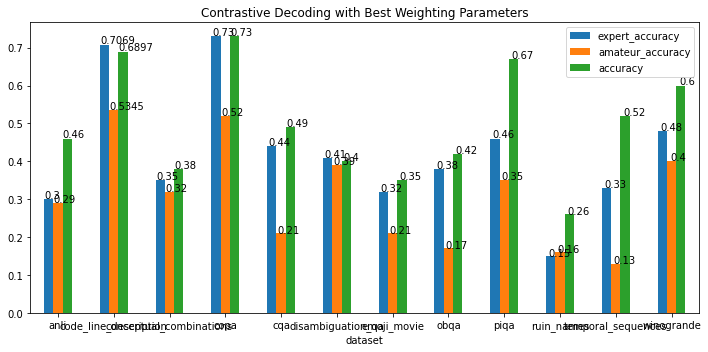

In [11]:
columns_to_keep = ["dataset", "weighting_parameter", "expert_accuracy", "amateur_accuracy", "accuracy"]
cd_best_df = cd_best_df[columns_to_keep]
# plot with bar
fig, ax = plt.subplots(figsize=(10, 5))
cd_best_df.plot.bar(x="dataset", 
                    y=["expert_accuracy", "amateur_accuracy", "accuracy"], 
                    ax=ax,
                    title="Contrastive Decoding with Best Weighting Parameters",
                    rot=0)
# add numbers to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()
plt.savefig("cd_best.png", dpi=300)


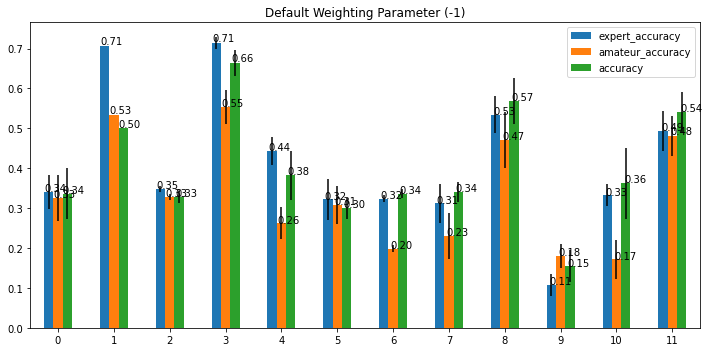

In [16]:
# only keep the foloowin
columns_to_keep = ["dataset", "expert_accuracy", "amateur_accuracy", "accuracy", "seed"]
cd_default_df = cd_default_df[columns_to_keep]

# group by seed
groups = cd_default_df.groupby(['dataset'])[["expert_accuracy", "amateur_accuracy", "accuracy"]]
# get the mean of each group
default_mean = groups.mean().reset_index()
default_std = groups.std().reset_index()

# plot with bar
fig, ax = plt.subplots(figsize=(10, 5))
default_mean.plot.bar(
                        # x="dataset",
                        y=["expert_accuracy", "amateur_accuracy", "accuracy"],
                        yerr=default_std,
                        ax=ax,
                        title="Default Weighting Parameter (-1)",
                        rot=0)
# add numbers to each bar, with at most 3 decimal places
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()
plt.savefig("cd_default.png", dpi=300)

In [14]:
p.get_height()

0.54

IndexError: index 0 is out of bounds for axis 0 with size 0

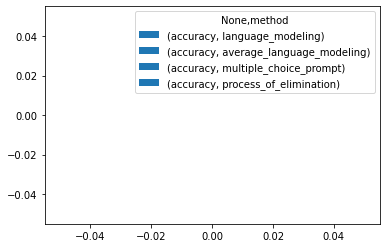

In [6]:
models = ["facebook/opt-iml-1.3b", "facebook/opt-iml-max-1.3b", "google/flan-t5-large", "google/flan-t5-xl"]
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
anli_df = df[(df["dataset"] == "anli") & (df["checkpoint"].isin(models))]

anli_df = anli_df.groupby(["checkpoint","method"])
anli_means = anli_df.mean().unstack().reindex(method_index, axis="columns")
anli_errors = anli_df.std().unstack().reindex(method_index, axis="columns")

fig, ax = plt.subplots()

anli_means.plot.bar(yerr=anli_errors, ax=ax, capsize=4, rot=0)
# plot horizontal lines corresponding to y labels
# for y in [0.4, 0.5]:
#     ax.axhline(y, color="black", linestyle="--", alpha=0.5)
